In [53]:
!pip install tensorflow==2.12.0
!pip install keras

In [54]:
!pip install pandas pillow

In [55]:
!pip install pandas
!pip install opencv-python

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.utils.class_weight import compute_class_weight

# Set constants
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE
PATCH_SIZE = 16
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
EMBED_DIM = 64
NUM_HEADS = 4
FF_DIM = 128
NUM_LAYERS = 6

# Path to dataset
dataset_path = '/kaggle/input/betta-fish-dataset/Betta Fish Dataset/dataset-bettafish'

# Load dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Class Names:", class_names)

# Unified rescaling layer
rescale_layer = layers.Rescaling(1./255)

# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

# Preprocessing function
def preprocess(ds, augment=False):
    ds = ds.map(lambda x, y: (rescale_layer(x), y), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=AUTOTUNE)
    return ds.prefetch(buffer_size=AUTOTUNE)

train_ds = preprocess(train_ds, augment=True)
val_ds = preprocess(val_ds, augment=False)

# Compute class weights safely
all_labels = []
for _, label in train_ds.unbatch():
    all_labels.append(label.numpy())
labels = np.array(all_labels)

class_weights_raw = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = {i: w for i, w in enumerate(class_weights_raw)}
print("Class Weights:", class_weights)

# Patch creation layer
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID"
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Patch encoder layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patches):
        positions = tf.range(start=0, limit=tf.shape(patches)[1], delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded

# MLP block
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Transformer block
def transformer_block(x, num_heads, projection_dim, transformer_units, dropout_rate):
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)(x1, x1)
    x2 = layers.Add()([attention_output, x])
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=[transformer_units, projection_dim], dropout_rate=dropout_rate)
    return layers.Add()([x3, x2])

# Build ViT model
def build_vit_model(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), num_classes=num_classes):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(PATCH_SIZE)(inputs)
    encoded_patches = PatchEncoder(NUM_PATCHES, EMBED_DIM)(patches)

    for _ in range(NUM_LAYERS):
        encoded_patches = transformer_block(encoded_patches, NUM_HEADS, EMBED_DIM, FF_DIM, dropout_rate=0.1)

    x = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(0.1)(x)
    x = mlp(x, hidden_units=[FF_DIM], dropout_rate=0.1)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs)



Found 13134 files belonging to 10 classes.
Using 10508 files for training.
Found 13134 files belonging to 10 classes.
Using 2626 files for validation.
Class Names: ['Crowntail Black Orchid', 'Crowntail Super Red', 'Halfmoon Big Ear', 'Halfmoon Blue', 'Halfmoon Multicolor', 'Halfmoon Nemo', 'Halfmoon Red', 'Halfmoon Red Cooper', 'Plakat Blue Rim', 'Plakat Platinum']
Class Weights: {0: 0.987593984962406, 1: 1.0172313649564375, 2: 0.987593984962406, 3: 1.0103846153846154, 4: 0.9793103448275862, 5: 1.0123314065510598, 6: 0.9941343424787134, 7: 1.0152657004830918, 8: 0.9979107312440646, 9: 0.9998097050428164}


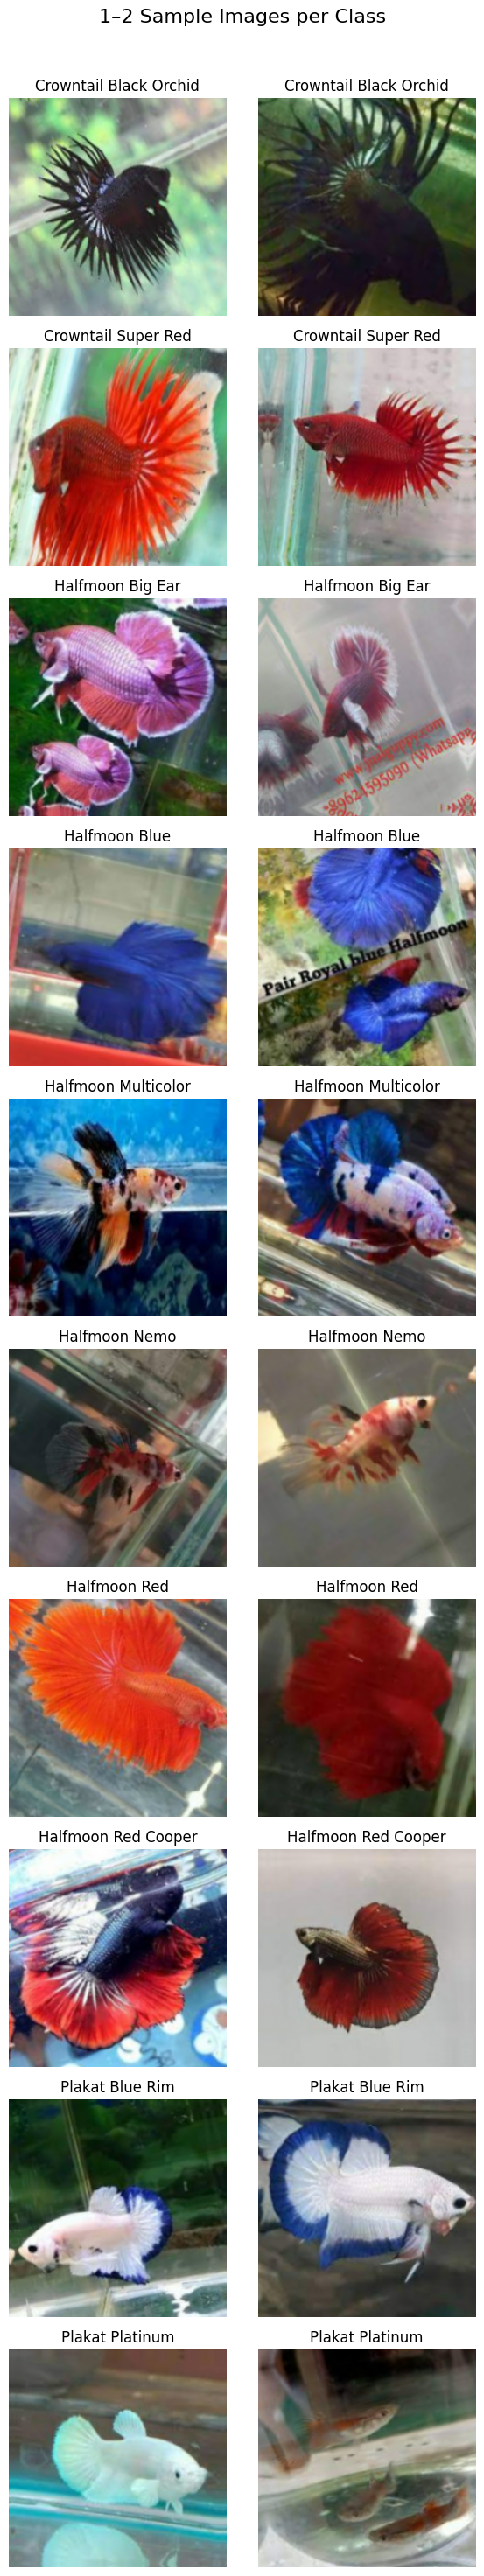

In [71]:
import matplotlib.pyplot as plt

# Build a dictionary to store 2 images per class
class_samples = {class_name: [] for class_name in class_names}

# Loop through unbatched dataset to collect samples
for image, label in train_ds.unbatch():
    class_name = class_names[label.numpy()]
    if len(class_samples[class_name]) < 2:
        class_samples[class_name].append(image)
    # Stop if we have 2 images for every class
    if all(len(imgs) == 2 for imgs in class_samples.values()):
        break

# Plot the collected samples
fig, axes = plt.subplots(len(class_names), 2, figsize=(6, 3 * len(class_names)))
fig.suptitle("1–2 Sample Images per Class", fontsize=16)

for i, class_name in enumerate(class_names):
    for j in range(2):
        ax = axes[i, j] if len(class_names) > 1 else axes[j]
        if j < len(class_samples[class_name]):
            img = (class_samples[class_name][j].numpy() * 255).astype("uint8")  # Fix here
            ax.imshow(img)
            ax.axis("off")
            ax.set_title(f"{class_name}")
        else:
            ax.axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()


In [ ]:
def visualize_one_patch_per_class(dataset, class_names, patch_size):
    collected = {}

    # Unbatch if not already
    dataset = dataset.unbatch()

    for img, label in dataset:
        label = label.numpy()
        class_name = class_names[label]
        if class_name not in collected:
            collected[class_name] = img
        if len(collected) == len(class_names):
            break

    for class_name, image in collected.items():
        print(f"Class: {class_name}")
        image_disp = (image.numpy() * 255).astype("uint8")

        plt.figure(figsize=(3, 3))
        plt.imshow(image_disp)
        plt.axis("off")
        plt.title(f"Original: {class_name}")
        plt.show()

        patches_layer = Patches(patch_size)
        normalized_img = tf.expand_dims(image, axis=0)
        patches = patches_layer(normalized_img)
        print(f"{class_name} - Patches shape: {patches.shape}")

        num_patches = patches.shape[1]
        plt.figure(figsize=(4, 4))
        for i in range(min(16, num_patches)):
            patch = patches[0, i]
            patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
            patch_img = tf.clip_by_value(patch_img, 0.0, 1.0).numpy()
            plt.subplot(4, 4, i + 1)
            plt.imshow(patch_img)
            plt.axis("off")
        plt.suptitle(f"Patches: {class_name}")
        plt.tight_layout()
        plt.show()


Class: Plakat Blue Rim


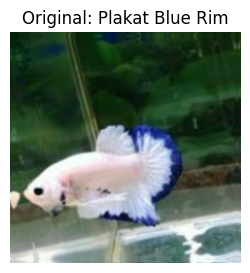

Plakat Blue Rim - Patches shape: (1, 196, 768)


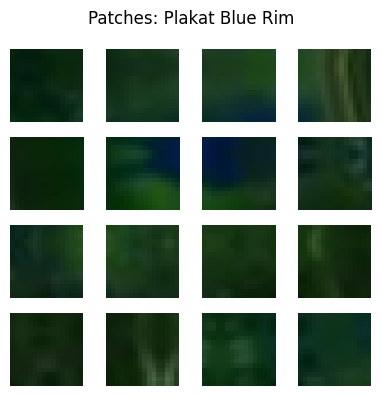

Class: Crowntail Super Red


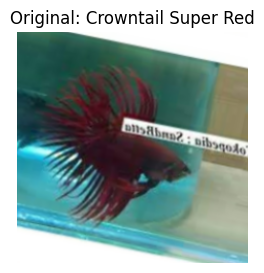

Crowntail Super Red - Patches shape: (1, 196, 768)


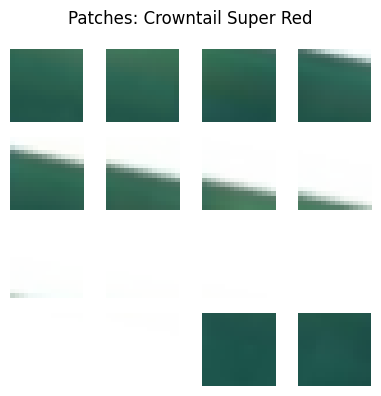

Class: Halfmoon Red


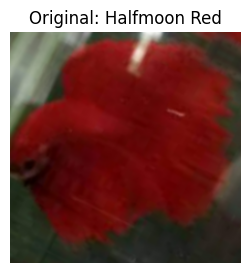

Halfmoon Red - Patches shape: (1, 196, 768)


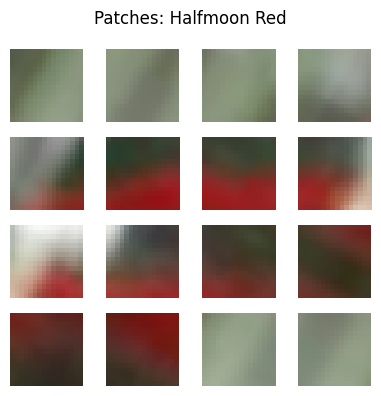

Class: Halfmoon Red Cooper


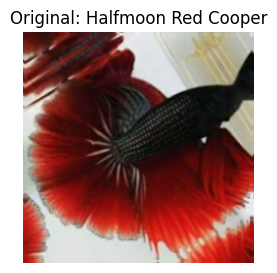

Halfmoon Red Cooper - Patches shape: (1, 196, 768)


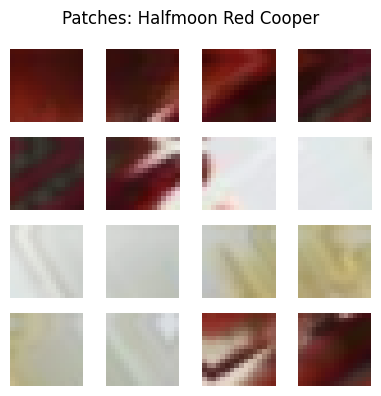

Class: Halfmoon Blue


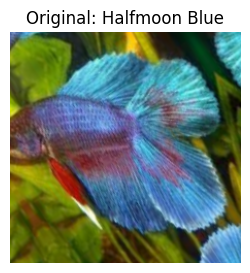

Halfmoon Blue - Patches shape: (1, 196, 768)


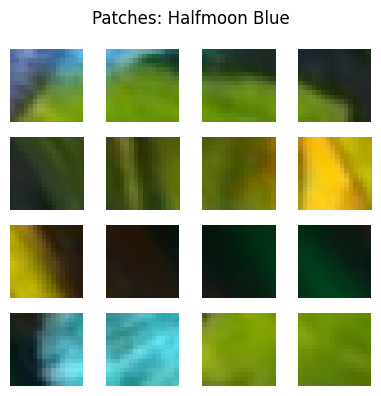

Class: Halfmoon Nemo


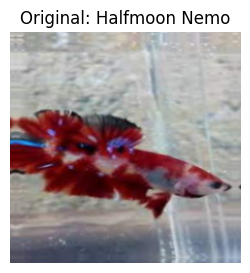

Halfmoon Nemo - Patches shape: (1, 196, 768)


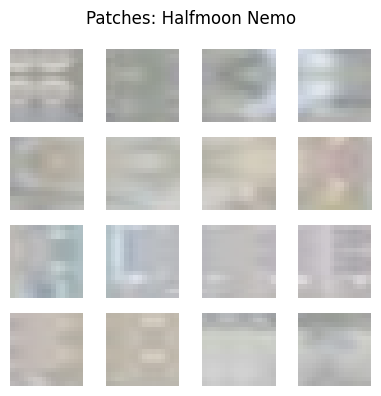

Class: Crowntail Black Orchid


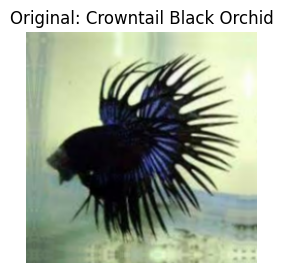

Crowntail Black Orchid - Patches shape: (1, 196, 768)


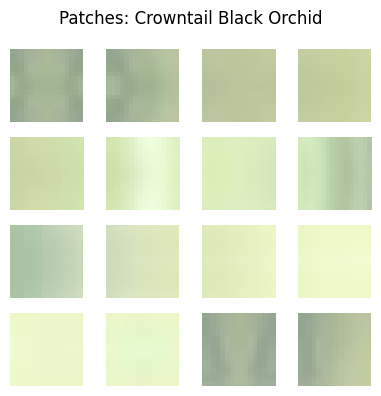

Class: Halfmoon Big Ear


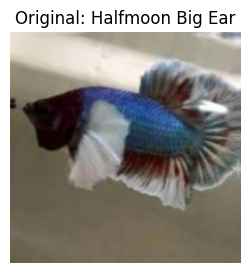

Halfmoon Big Ear - Patches shape: (1, 196, 768)


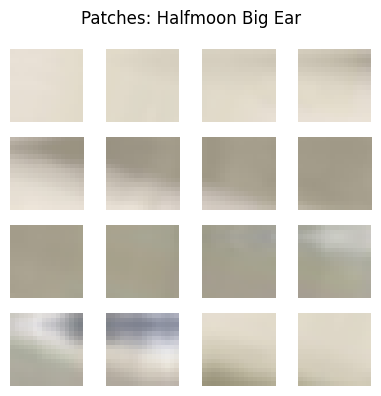

Class: Halfmoon Multicolor


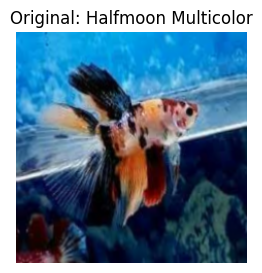

Halfmoon Multicolor - Patches shape: (1, 196, 768)


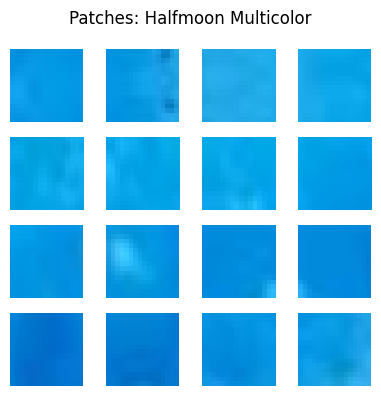

Class: Plakat Platinum


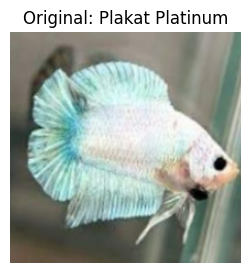

Plakat Platinum - Patches shape: (1, 196, 768)


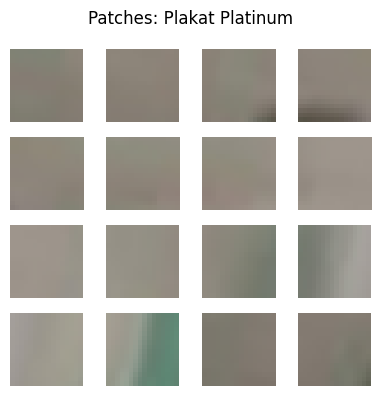

In [59]:
visualize_one_patch_per_class(train_ds, class_names, patch_size=PATCH_SIZE)


In [60]:
# Build and compile the model
vit_model = build_vit_model()
vit_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Print model summary
vit_model.summary()

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint("vit_model.h5", save_best_only=True)
earlystop_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 patches_51 (Patches)           (None, None, 768)    0           ['input_2[0][0]']                
                                                                                                  
 patch_encoder_1 (PatchEncoder)  (None, None, 64)    61760       ['patches_51[0][0]']             
                                                                                                  
 layer_normalization_13 (LayerN  (None, None, 64)    128         ['patch_encoder_1[0][0]']  

In [61]:
# Train the model
history = vit_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb],
    class_weight=class_weights
)


Epoch 1/10
329/329 [==============================] - 455s 1s/step - loss: 1.7829 - accuracy: 0.3148 - val_loss: 1.4541 - val_accuracy: 0.4463
Epoch 2/10
329/329 [==============================] - 448s 1s/step - loss: 1.1864 - accuracy: 0.5618 - val_loss: 0.8376 - val_accuracy: 0.6874
Epoch 3/10
329/329 [==============================] - 440s 1s/step - loss: 0.7899 - accuracy: 0.7254 - val_loss: 0.6165 - val_accuracy: 0.7963
Epoch 4/10
329/329 [==============================] - 441s 1s/step - loss: 0.5860 - accuracy: 0.7980 - val_loss: 0.4942 - val_accuracy: 0.8355
Epoch 5/10
329/329 [==============================] - 440s 1s/step - loss: 0.4544 - accuracy: 0.8507 - val_loss: 0.3452 - val_accuracy: 0.8896
Epoch 6/10
329/329 [==============================] - 440s 1s/step - loss: 0.3762 - accuracy: 0.8732 - val_loss: 0.2790 - val_accuracy: 0.9166
Epoch 7/10
329/329 [==============================] - 439s 1s/step - loss: 0.3058 - accuracy: 0.8972 - val_loss: 0.2289 - val_accuracy: 0.9341

In [62]:
# Evaluate the model
loss, accuracy = vit_model.evaluate(val_ds)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

83/83 [==============================] - 31s 366ms/step - loss: 0.1455 - accuracy: 0.9612
Validation Accuracy: 96.12%


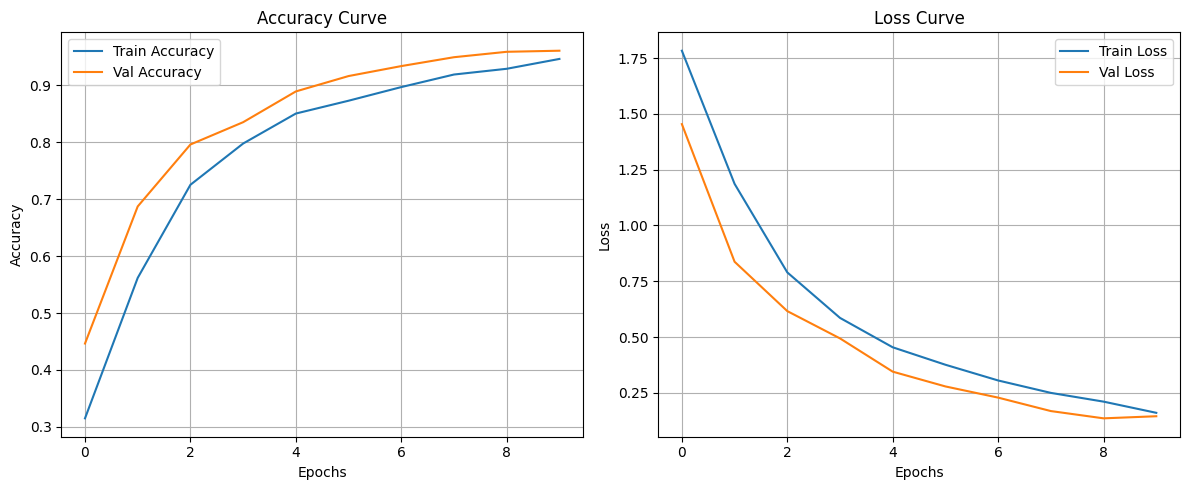

In [63]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy plot
axs[0].plot(history.history["accuracy"], label="Train Accuracy")
axs[0].plot(history.history["val_accuracy"], label="Val Accuracy")
axs[0].set_title("Accuracy Curve")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Accuracy")
axs[0].legend()
axs[0].grid(True)

# Loss plot
axs[1].plot(history.history["loss"], label="Train Loss")
axs[1].plot(history.history["val_loss"], label="Val Loss")
axs[1].set_title("Loss Curve")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Loss")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


In [64]:
#Evaluate
true_labels = []
pred_labels = []

for images, labels in val_ds:
    preds = vit_model.predict(images)
    true_labels.extend(labels.numpy())
    pred_labels.extend(np.argmax(preds, axis=1))

1/1 [==============================] - 1s 807ms/step


Classification Report:
                         precision    recall  f1-score   support

Crowntail Black Orchid       0.99      1.00      0.99       244
   Crowntail Super Red       0.96      0.94      0.95       281
      Halfmoon Big Ear       0.94      0.92      0.93       250
         Halfmoon Blue       1.00      1.00      1.00       274
   Halfmoon Multicolor       0.94      0.91      0.93       241
         Halfmoon Nemo       0.94      0.98      0.96       276
          Halfmoon Red       0.91      1.00      0.95       257
   Halfmoon Red Cooper       1.00      0.99      0.99       279
       Plakat Blue Rim       0.98      0.97      0.98       261
       Plakat Platinum       0.95      0.89      0.92       263

              accuracy                           0.96      2626
             macro avg       0.96      0.96      0.96      2626
          weighted avg       0.96      0.96      0.96      2626



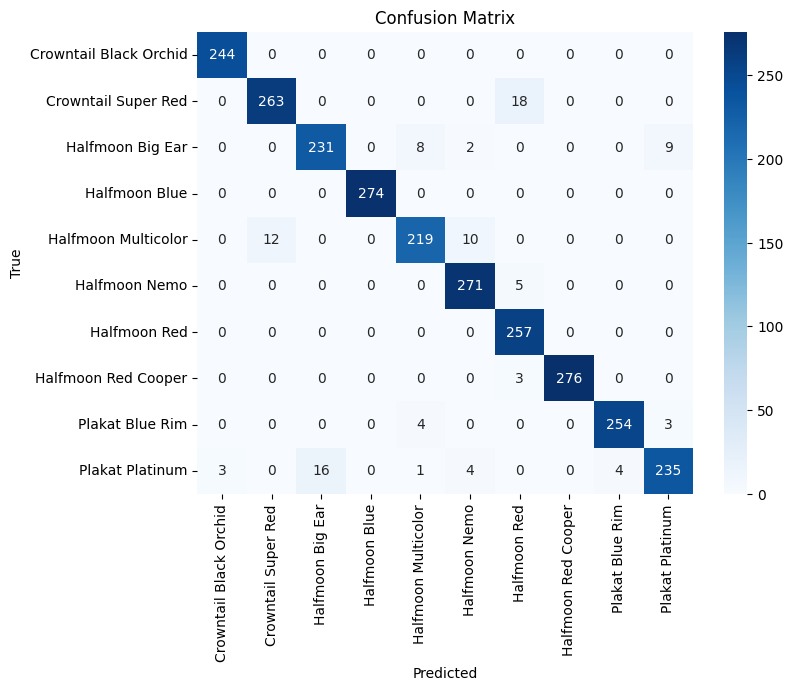

In [65]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = vit_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)
report = classification_report(y_true, y_pred, target_names=class_names)

# Print classification report
print("Classification Report:\n", report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

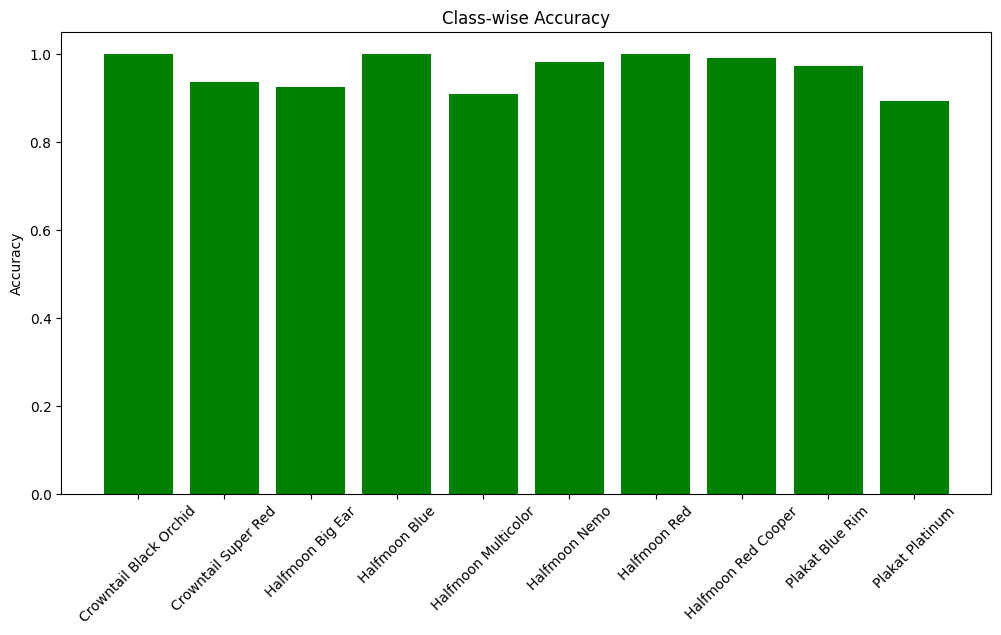

In [66]:
# Class-wise Accuracy Visualization
class_counts = dict.fromkeys(class_names, 0)
correct_counts = dict.fromkeys(class_names, 0)

for true, pred in zip(true_labels, pred_labels):
    class_counts[class_names[true]] += 1
    if true == pred:
        correct_counts[class_names[true]] += 1

classwise_acc = {cls: correct_counts[cls]/class_counts[cls] for cls in class_names}

plt.figure(figsize=(12, 6))
plt.bar(classwise_acc.keys(), classwise_acc.values(), color='green')
plt.xticks(rotation=45)
plt.ylabel("Accuracy")
plt.title("Class-wise Accuracy")
plt.show()

In [67]:
# Test with New Image

def predict_image(img_path):
    img = tf.keras.utils.load_img(img_path, target_size=(IMAGE_SIZE, IMAGE_SIZE))
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = tf.expand_dims(img_array, 0)
    predictions = vit_model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]
    confidence = np.max(tf.nn.softmax(predictions))
    print(f"Predicted: {predicted_class} ({confidence:.2%})")

In [69]:
img_path = '/kaggle/input/testing/test3.jpg'  # Use the actual path from the upload
predict_image(img_path)

1/1 [==============================] - 0s 33ms/step
Predicted: Halfmoon Blue (23.16%)


In [70]:
img_path = '/kaggle/input/testing/test2.jfif'  # Use the actual path from the upload
predict_image(img_path)

1/1 [==============================] - 0s 32ms/step
Predicted: Halfmoon Big Ear (23.02%)
